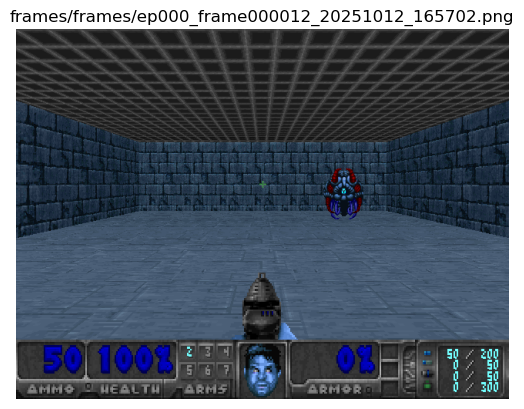

In [1]:
import boto3
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import io

s3 = boto3.client("s3")
key = "frames/frames/ep000_frame000012_20251012_165702.png"
bucket = "doom-cnn-frames"
obj = s3.get_object(Bucket=bucket, Key=key)

img = Image.open(io.BytesIO(obj["Body"].read())).convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.title(key)
plt.show()

In [2]:
import boto3, json

bucket = "doom-cnn-frames"
json_key = "episode_simple_000.json"

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket, Key=json_key)
data = json.loads(obj["Body"].read().decode("utf-8"))

print(f"Loaded {len(data)} frames from s3://{bucket}/{json_key}")
print("First item:\n", json.dumps(data[0], indent=2))


Loaded 6161 frames from s3://doom-cnn-frames/episode_simple_000.json
First item:
 {
  "frame": 12,
  "timestamp": 1760313422.639301,
  "screen_shape": [
    480,
    640,
    3
  ],
  "action": [
    true,
    false,
    false
  ],
  "action_names": [
    "move_left",
    "move_right",
    "attack"
  ],
  "game_variables": [],
  "episode": 0,
  "frame_path": "frames/frames/ep000_frame000012_20251012_165702.png",
  "reward": -1.0
}


In [2]:
import json, boto3, numpy as np

s3 = boto3.client("s3")

def load_and_filter_single_episode_s3_json(
    bucket: str,
    json_key: str
):
    """
    Load a single episode JSON file from S3 and filter out frames with no actions.
    Does NOT modify frame_path values.

    Returns:
        filtered_data: list of valid frame entries
        total_frames: number of frames before filtering
    """
    print(f"Loading s3://{bucket}/{json_key}")
    obj = s3.get_object(Bucket=bucket, Key=json_key)
    episode = json.loads(obj["Body"].read().decode("utf-8"))

    total_frames = len(episode)
    filtered = [f for f in episode if any(f.get("action", []))]

    print(f"Total frames: {total_frames}")
    print(f"Frames with actions: {len(filtered)}")
    print(f"Frames without actions: {total_frames - len(filtered)}")

    if filtered:
        actions = np.array([f["action"] for f in filtered], dtype=int)
        print("\nAction distribution:")
        print(f"  Move Left :  {actions[:,0].sum()}")
        print(f"  Move Right:  {actions[:,1].sum()}")
        print(f"  Attack    :  {actions[:,2].sum()}")

    return filtered, total_frames


In [3]:
filtered_data, total_frames = load_and_filter_single_episode_s3_json(
    bucket="doom-cnn-frames",
    json_key="episode_simple_000.json"
)


Loading s3://doom-cnn-frames/episode_simple_000.json
Total frames: 6161
Frames with actions: 6161
Frames without actions: 0

Action distribution:
  Move Left :  2444
  Move Right:  2474
  Attack    :  1478


In [11]:
# --- ONE-TIME PREPROCESS TO JPEG (160x120) ---
import os
import subprocess
from PIL import Image

# ===== CONFIG =====
S3_URI = "s3://doom-cnn-frames"                              # your dataset bucket/prefix
BASE_DIR_RAW = "/home/sagemaker-user/doom_data"              # where raw files live (synced)
BASE_DIR_PREPROC = "/home/sagemaker-user/doom_data_preprocessed"  # resized JPEGs go here
IMG_HEIGHT = 160
IMG_WIDTH  = 120
JPEG_QUALITY = 90

print(f"Target JPEG size: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Raw dir: {BASE_DIR_RAW}")
print(f"Preprocessed dir: {BASE_DIR_PREPROC}")

# ===== 1) SYNC FROM S3 (if not already local) =====
os.makedirs(BASE_DIR_RAW, exist_ok=True)
if not os.path.exists(os.path.join(BASE_DIR_RAW, "frames")):
    print("Syncing from S3 → local (may take a few minutes)...")
    subprocess.run(["aws", "s3", "sync", S3_URI, BASE_DIR_RAW], check=True)
    print("✓ Sync complete.")
else:
    print("Local raw dataset already exists — skipping sync.")

# ===== 2) CREATE PREPROCESSED FOLDER STRUCTURE =====
os.makedirs(os.path.join(BASE_DIR_PREPROC, "frames/frames"), exist_ok=True)

SRC_ROOT = os.path.join(BASE_DIR_RAW, "frames/frames")
DST_ROOT = os.path.join(BASE_DIR_PREPROC, "frames/frames")

converted, skipped = 0, 0

# ===== 3) PROCESS ALL IMAGES =====
for root, _, files in os.walk(SRC_ROOT):
    for fname in files:
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        src = os.path.join(root, fname)
        dst_rel = os.path.relpath(src, BASE_DIR_RAW)
        dst = os.path.join(BASE_DIR_PREPROC, os.path.splitext(dst_rel)[0] + ".jpg")
        os.makedirs(os.path.dirname(dst), exist_ok=True)

        if os.path.exists(dst):
            skipped += 1
            continue

        try:
            with Image.open(src).convert("RGB") as img:
                img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR)
                img.save(dst, format="JPEG", quality=JPEG_QUALITY, optimize=True)
            converted += 1
        except Exception as e:
            print(f"⚠️ Failed to process {src}: {e}")

print(f"\n✅ JPEG preprocessing complete!")
print(f"Converted: {converted} | Skipped(existing): {skipped}")
print(f"Output folder: {DST_ROOT}")


Target JPEG size: 120x160
Raw dir: /home/sagemaker-user/doom_data
Preprocessed dir: /home/sagemaker-user/doom_data_preprocessed
Local raw dataset already exists — skipping sync.

✅ JPEG preprocessing complete!
Converted: 6161 | Skipped(existing): 0
Output folder: /home/sagemaker-user/doom_data_preprocessed/frames/frames


In [13]:
# dataloader_jpeg.py  — minimal, streaming loader for preprocessed JPEGs

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ===== Config (match your preprocessing) =====
BASE_DIR = "/home/sagemaker-user/doom_data_preprocessed"   # <- preprocessed JPEG root
IMG_HEIGHT = 160
IMG_WIDTH  = 120
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

def _to_abs(rel_path: str) -> str:
    """Join relative 'frames/frames/...' to preprocessed base dir."""
    return os.path.join(BASE_DIR, rel_path)

def _paths_and_labels(records):
    """
    records = filtered_data list where each item has:
      - 'frame_path': 'frames/frames/....png'  (JSON unchanged)
      - 'action': [bool, bool, bool]
    We map .png -> .jpg because we saved preprocessed images as JPEG.
    """
    rels = []
    for r in records:
        rp = r["frame_path"]
        root, _ = os.path.splitext(rp)
        rels.append(root + ".jpg")   # point to JPEG mirror

    paths  = np.array([_to_abs(p) for p in rels])
    labels = np.array([[float(v) for v in r["action"]] for r in records], dtype=np.float32)
    return paths, labels

def _load_jpeg_tf(path, label):
    """
    TensorFlow-native JPEG decode -> float32 [0,1].
    Preprocessed images are already 160x120; resize kept as a guard.
    """
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)     # [0,1]
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])     # safety net
    return img, label

def _make_dataset(paths_np, labels_np, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths_np, labels_np))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(paths_np), 4000))
    ds = ds.map(_load_jpeg_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    # Throughput > determinism for training
    opts = tf.data.Options()
    opts.experimental_deterministic = False
    return ds.with_options(opts)

def build_datasets_from_filtered(filtered_data):
    """
    Build train/val tf.data datasets from your filtered_data list.
    Returns: train_dataset, val_dataset, (n_train, n_val)
    """
    if not filtered_data:
        raise ValueError("filtered_data is empty. Load your episode JSON and filter first.")

    # File list + labels (small; safe in RAM)
    paths, labels = _paths_and_labels(filtered_data)

    # Split
    p_train, p_val, y_train, y_val = train_test_split(
        paths, labels, test_size=VALIDATION_SPLIT, random_state=42
    )
    print(f"Train files: {len(p_train)} | Val files: {len(p_val)}")

    # Streaming datasets
    train_ds = _make_dataset(p_train, y_train, shuffle=True)
    val_ds   = _make_dataset(p_val,   y_val,   shuffle=False)
    return train_ds, val_ds, (len(p_train), len(p_val))


# ===== Example usage (uncomment in your notebook) =====
# filtered_data, _ = load_and_filter_single_episode_s3_json(
#     bucket="doom-cnn-frames",
#     json_key="episodes/episode_simple_000_20251012_165702.json"
# )
train_dataset, val_dataset, (n_train, n_val) = build_datasets_from_filtered(filtered_data)
print("Datasets ready.")


Train files: 4928 | Val files: 1233
Datasets ready.


In [14]:
# --- CNN Model Definition for Action Prediction ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assume these constants are already defined in your preprocessing cell
# IMG_HEIGHT = 160
# IMG_WIDTH = 120

def build_action_prediction_cnn(input_shape=(160, 120, 3), num_actions=3):
    """
    Build a custom CNN for action prediction.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_actions: Number of action outputs (3: left, right, attack)
    
    Returns:
        Compiled Keras model
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Convolutional Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer: 3 independent sigmoid outputs for multi-label classification
        layers.Dense(num_actions, activation='sigmoid', name='action_outputs')
    ])
    
    return model

# Build the model
model = build_action_prediction_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_actions=3)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'binary_accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("✅ Model built and compiled successfully!")
model.summary()


✅ Model built and compiled successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 160, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 160, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 160, 120, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 160, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 80, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 80, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 80, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 80, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 80, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 80, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 40, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 40, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 40, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 40, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 40, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 40, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 20, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 20, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,879,779 (10.99 MB)

 Trainable params: 2,878,115 (10.98 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [15]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
        keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]
)

Epoch 1/20
 97/154 ━━━━━━━━━━━━━━━━━━━━ 4:50 5s/step - binary_accuracy: 0.7951 - loss: 0.4727 - precision: 0.6682 - recall: 0.8382

KeyboardInterrupt: 